# Implementing  BVEP brain network model in Stan


In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import re
import glob
from itertools import chain
from operator import itemgetter

import json
import pickle

import scikitplot as skplt
from sklearn.metrics import confusion_matrix

from scipy.optimize import fsolve
from scipy.optimize import root

In [3]:
from lib.parse_csv import parse_csv2
from lib.read_csvs import read_samples

from lib.report_nodetype import node_EzPzHz_idex
from lib.report_metrics import LSE, Err, RMSE, LSE_obs, z_score, shrinkage
from lib.report_nodetype import node_score_std_extrm, node_score_ezpz

In [4]:
import warnings
import yaml

warnings.filterwarnings('ignore')
warnings.simplefilter(action="ignore", category=FutureWarning)
yaml.warnings({'YAMLLoadWarning': False})

In [5]:
%pylab inline
#%matplotlib inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


In [6]:
def f_int(x):
    return np.int(x)

f_vector_int = np.vectorize(f_int)

In [7]:
numbers = re.compile(r'(\d+)')

def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

# Syntetic Data

In [8]:
data_dir = 'data_input_files'
results_dir = 'data_output_files'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

In [9]:
cwd = os.getcwd()
print("The results directory is:", cwd)

The results directory is: /data/BVEP_SEEG_benchmark


In [10]:
#Res_dir='data_output_files''
Res_dir='Res_BVEP_seeg_noncentered_reparam_benchmark_NUTS'

In [11]:
Mainpath =cwd+"/"

In [12]:
Reportmetrics_dir = os.path.join(cwd, Mainpath+"/data_output_files/figures/")

In [13]:
eta_true_inx, eta_true_mu, eta_true_sd = np.loadtxt(Mainpath+"ExperimentalData"+"/"+"eta_seeg_patient1"+".txt", delimiter=',', usecols=(0,1,2), skiprows=1, ).T 

In [14]:
with open(Mainpath+"ExperimentalData"+"/"+"true_labels_nodes_patient1"+".txt", 'r') as filehandle:  
          true_labels_nodes = json.load(filehandle)              

In [15]:
data_input = np.load(Mainpath+"data_input_files/"+"datainput_seeg_84nodes_patient1_euler.npz")
#data_input = np.load(f'{data_dir}/datainput_Seeg_84nodes_patient1.R.npz')

In [16]:
Obs_seeg = data_input['Obs_seeg']
x_source=data_input['x_source']
z_source=data_input['z_source']

SC = data_input['SC']
Gain = data_input['Gain']
ts = data_input['ts']
tau0 = data_input['tau0']
Ks = data_input['Ks']

ez_idx=data_input['ez_idx']
pz_idx=data_input['pz_idx']

ez_val=data_input['ez_val']
pz_val=data_input['pz_val']
hz_val=data_input['hz_val']

nn=data_input['nn']
ns=data_input['ns']
nt=data_input['nt']

In [17]:
nodes=np.r_[0:nn]

In [18]:
Obs_seeg.shape, x_source.shape

((130, 162), (130, 84))

In [19]:
I1=3.1
eta_c=-2.05        
delta_eta=1.0                  
prior_std =1.0
sd_thr=0.8

In [20]:
eta_ez= float(ez_val)
eta_pz= float(pz_val)
eta_hz= float(hz_val)

In [21]:
eta_ez, eta_pz, eta_hz

(-1.6, -2.4, -3.5)

In [22]:
ez_idx, pz_idx

(array([ 6, 34], dtype=int32), array([27,  5, 11], dtype=int32))

In [23]:
Ez_indices, Pz_indices, Hz_indices, Ez_arr, Pz_arr, Hz_arr= node_EzPzHz_idex(true_labels_nodes)

In [24]:
print("Ez_indices:", Ez_indices)
print("Pz_indices:", Pz_indices)

Ez_indices: [6, 34]
Pz_indices: [5, 11, 27]


## Observation

In [25]:
Obs_seeg.shape

(130, 162)

In [26]:
Seeg= Obs_seeg.T
Seeg.shape

(162, 130)

In [27]:
Seeg_area = np.trapz(Seeg, dx=0.0001)

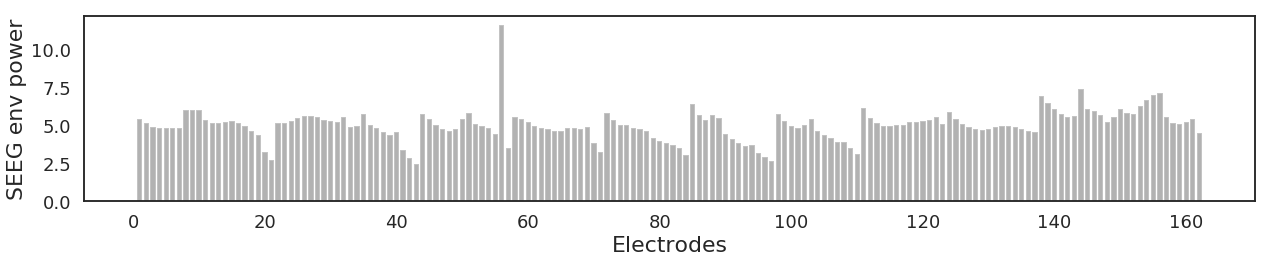

In [28]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1,Seeg_area.shape[0]+1), -Seeg_area, color='black', alpha=0.3);
plt.xlabel('Electrodes', fontsize=22)
plt.ylabel('SEEG env power', fontsize=22)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power.eps"), dpi=800)
plt.show()

In [29]:
Seeg_pwr = np.sum((Seeg*Seeg), axis=1)
Seeg_pwr_n = (Seeg_pwr/ Seeg_pwr.max())

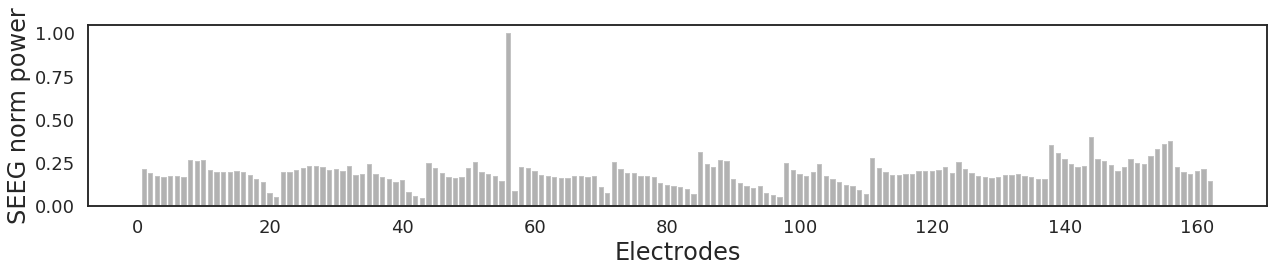

In [30]:
plt.figure(figsize=(18, 4))
plt.bar(np.arange(1, Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='black', alpha=0.3);
plt.xlabel('Electrodes', fontsize=24)
plt.ylabel('SEEG norm power', fontsize=24)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Obs_SEEG_envelop_power_normalize.eps"), dpi=800)
plt.show()

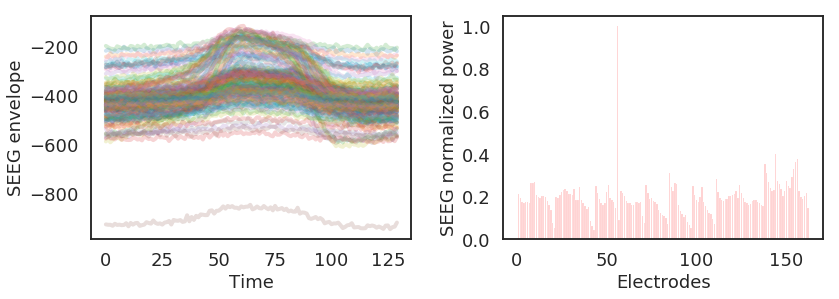

In [31]:
plt.figure(figsize=(12,4.5))
plt.subplot(121)
plt.plot(Seeg.T, linewidth=4, alpha=0.2);
plt.xlabel('Time', fontsize=18)
plt.ylabel('SEEG envelope', fontsize=18)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)

plt.subplot(122)
plt.bar(np.arange(1,Seeg_pwr_n.shape[0]+1), Seeg_pwr_n, color='r', alpha=0.2)
plt.xlabel('Electrodes', fontsize=18)
plt.ylabel('SEEG normalized power', fontsize=18)
plt.yticks(fontsize=18, rotation=0)
plt.xticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"Observed_SEEGdata.eps"), dpi=800)
plt.show()

In [32]:
xs=x_source
zs=z_source

xs.shape, zs.shape

((130, 84), (130, 84))

In [33]:
xs_pwr = (xs*xs).sum (axis=0)
xs_pwr_n = (xs_pwr/ xs_pwr.max())

In [34]:
eni_idx=np.argsort(xs_pwr)
eni_idx

array([ 6, 34, 27, 11,  5, 83,  9, 29,  7, 23, 60, 14, 13, 20,  3, 28, 54,
       22, 39, 35,  8, 19,  4, 26,  0,  2, 58, 72, 76, 37, 33, 52, 63, 10,
       57, 36, 25, 68, 56, 15, 42, 38, 31, 12, 53, 40, 69, 32, 46, 75, 64,
       77, 21, 71, 43, 59, 44, 78, 16, 82, 62, 45, 61, 70, 18, 17, 41,  1,
       24, 55, 47, 74, 48, 80, 51, 30, 81, 66, 73, 79, 67, 50, 65, 49])

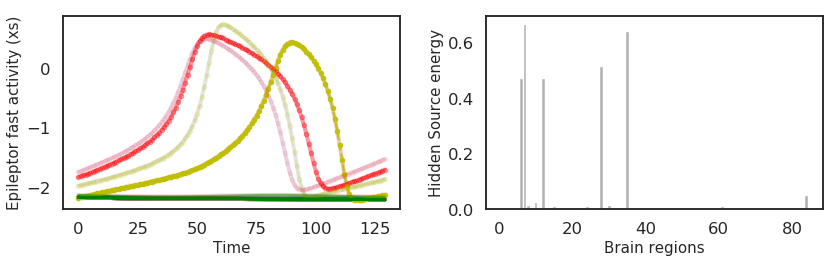

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(xs, linewidth=4, alpha=0.2);
for i in range(xs.shape[1]):
    if i in Ez_indices:
        plot(xs[:,i], linestyle='-', marker='.', linewidth=4, color='r', alpha=2./i)
    elif i in Pz_indices:
        plot(xs[:,i], linestyle='--', marker='.',linewidth=2, color='y', alpha=4./i)
    else: 
        plot(xs[:,i], linestyle='-', linewidth=2, color='g', alpha=0.5)
#plt.title('Hidden source level activity')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Epileptor fast activity (xs)', fontsize=15)
plt.subplot(122)
plt.bar(np.arange(1,xs_pwr_n.shape[0]+1), 1.-xs_pwr_n, color='black', alpha=0.3)
#plt.title('Normalized power of hidden source level activity'
plt.xlabel('Brain regions', fontsize=15)
plt.ylabel('Hidden Source energy', fontsize=15)
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"UnobserveSourceActivity.eps"), dpi=800)
plt.show()

In [36]:
Seeg.shape, xs.shape

((162, 130), (130, 84))

In [37]:
from lib.report_plots import plot_features, plot_zscore_shrinkage,  plot_posterior, ppplot, plot_obs_x, plot_obs_z, plot_hiddenstates_x, plot_hiddenstates_z, plot_confusion_matrix

In [38]:
from  lib.report_diagnostics_stan import  run_summary, Nuts_plot, check_rhat, check_div, check_treedepth, check_energy, check_n_eff

In [39]:
from lib.report_algconfigs import hmc_config

In [40]:
nSample=200

## Benchmark on BVEP parameterization and solvers 

## 1) Non-centerized form of parameterization,  sampling using eigen vectors of Gain Matrix, and with backward Euler integration in Stan

In [41]:
! cat BVEP1_seeg_noncentered_reparam.stan

data {
  int nn;  //number of brain regions
  int nt;  //number of data points per sensor
  int ns;  //number of sensors

  real dt;    //time step in Euler integration
  real tau0;  //time scale in Eipleptor model
  real I1;    //input current in in Eipleptor model
  real Ks;    //global connectivity parameter

  matrix[nt, ns] Obs_seeg;      // observation at sensor-level
  matrix[nn, nn] SC;           // brain structural connectivity
  matrix[ns, nn] Gain;         // gain (projection matrix)
  matrix[nn, nn] eigen_vec;   // eigen vectors of dot(Gain.T, Gain)
 
  real zlim[2]; 
  real xlim[2]; 
}

transformed data {
  vector[nt*ns] Obs_seeg_vect;
  Obs_seeg_vect=to_vector(Obs_seeg);
}

parameters {
  vector[nn] eta_star;
  vector[nn] x_init_star;
  vector[nn] z_init_star;
  real <lower=-1.0> K_star;
  real <lower=-1.0> amplitude_star;
  vector [ns] offset_star;
  real eps_star;
}

transformed parameters {
  vector[nn] eta;
  vector[nn] x_init;
  vector[nn] z_init;
  real K;
  real am

In [42]:
model=str('BVEP1_seeg_noncentered_reparam')

In [43]:
curr_dir=cwd

In [44]:
#! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir

In [45]:
# %%bash

# alg=hmc
# adap_delta=0.99
# max_depth=10
# num_iter=500
# warm_iter=2000

# model=BVEP1_seeg_noncentered_reparam
# data_input=datainput_seeg_84nodes_patient1_euler.R
# data_output=data_output_${alg}_${model}

# mkdir -p ${data_output}


# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
#         adapt \
#         delta=${adap_delta} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${max_depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_$i.out &
# done
# #wait

In [46]:
fit_foldername="data_output_hmc_"+model
fit_filename="output_hmc_"+model

In [47]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP1_seeg_noncentered_reparam'

In [48]:
! ls $dir_data_output

output_hmc_BVEP1_seeg_noncentered_reparam_1.csv
output_hmc_BVEP1_seeg_noncentered_reparam_1.out
output_hmc_BVEP1_seeg_noncentered_reparam_2.csv
output_hmc_BVEP1_seeg_noncentered_reparam_2.out
output_hmc_BVEP1_seeg_noncentered_reparam_3.csv
output_hmc_BVEP1_seeg_noncentered_reparam_3.out
output_hmc_BVEP1_seeg_noncentered_reparam_4.csv
output_hmc_BVEP1_seeg_noncentered_reparam_4.out
summary_output_hmc_BVEP1_seeg_noncentered_reparam_1.csv


In [49]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP1_seeg_noncentered_reparam/output_hmc_BVEP1_seeg_noncentered_reparam_1.out <==
               147913 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP1_seeg_noncentered_reparam/output_hmc_BVEP1_seeg_noncentered_reparam_2.out <==
               150403 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP1_seeg_noncentered_reparam/output_hmc_BVEP1_seeg_noncentered_reparam_3.out <==
               142653 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP1_seeg_noncentered_reparam/output_hmc_BVEP1_seeg_noncentered_reparam_4.out <==
               148091 seconds (Total)



## BVEP1 all chains

In [50]:
nchains=4

In [51]:
run_time_bvep1_euler=np.zeros((nchains,1))
lp_bvep1_euler=np.zeros((nchains, nSample))
divergent_bvep1_euler=np.zeros((nchains, nSample))
stepsize_bvep1_euler=np.zeros((nchains, nSample))
Seeg_est_bvep1_euler=np.zeros((nchains, nSample, nt, ns))
x_est_bvep1_euler=np.zeros((nchains, nSample, nn, nt))
z_est_bvep1_euler=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep1_euler=np.zeros((nchains, nSample, nn))

In [52]:
for i in np.arange(0,nchains):
    
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

        with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
            lines = f.readlines()
            last_lines = lines[-7:]
            total_time_bvep1_euler=float(re.findall("\d+.\d+", last_lines[5])[0])
            print("convergence took: %s seconds " % total_time_bvep1_euler)
            
        run_time_bvep1_euler[i,0]=total_time_bvep1_euler
        
        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=int(num_samples),  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep1_euler[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep1_euler[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep1_euler[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep1_euler[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep1_euler[i,]=dict_samples['x'][-nSample:]
        z_est_bvep1_euler[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep1_euler[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP1_seeg_noncentered_reparam_1.csv
convergence took: 147913.0 seconds 
reading ... output_hmc_BVEP1_seeg_noncentered_reparam_2.csv
convergence took: 150403.0 seconds 
reading ... output_hmc_BVEP1_seeg_noncentered_reparam_3.csv
convergence took: 142653.0 seconds 
reading ... output_hmc_BVEP1_seeg_noncentered_reparam_4.csv
convergence took: 148091.0 seconds 


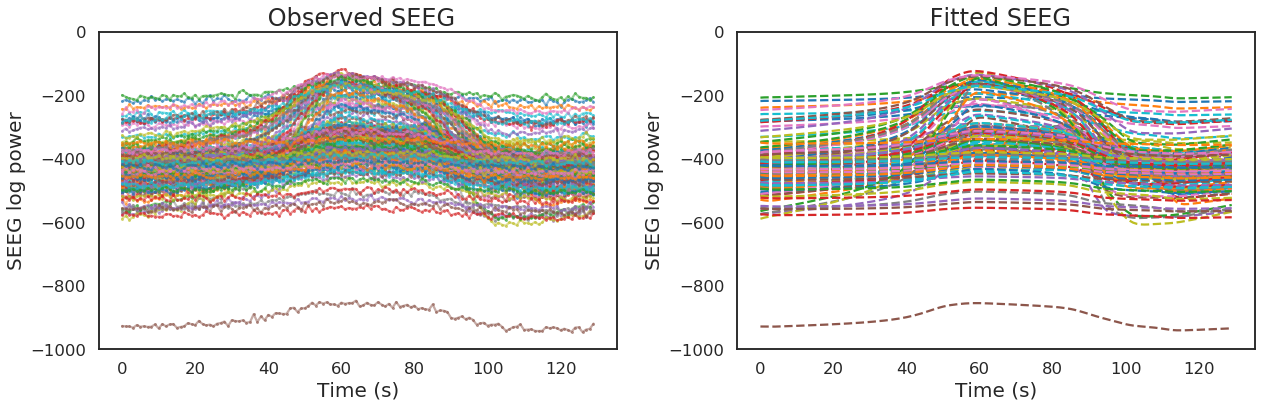

In [53]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep1_euler, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

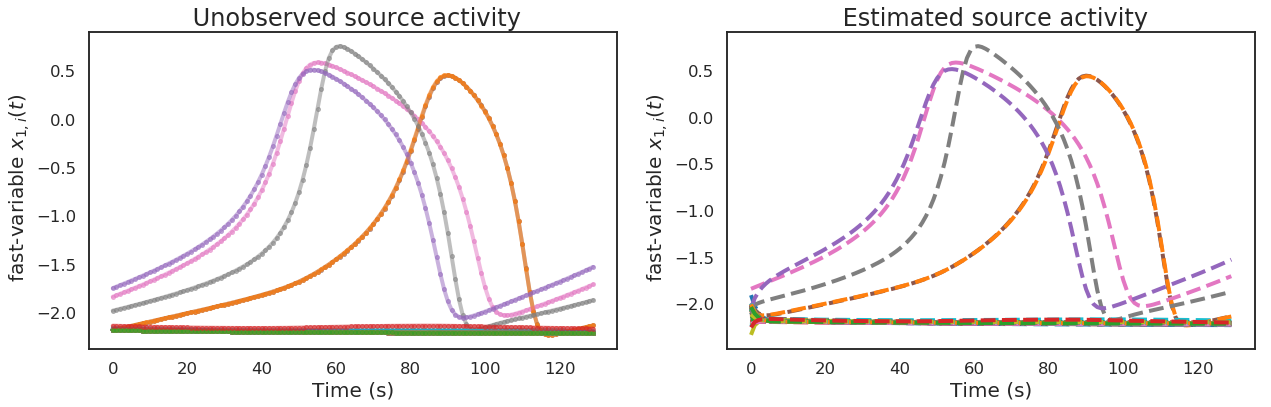

In [54]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep1_euler, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

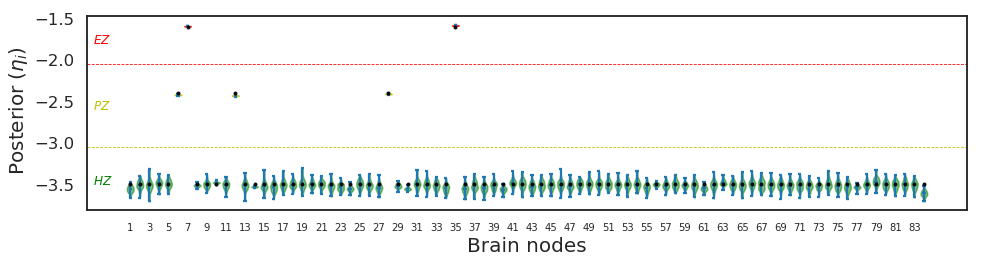

In [55]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep1_euler, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [56]:
np.mean(lp_bvep1_euler, axis=1)

array([-68744.0265, -68745.6   , -68745.0825, -68744.586 ])

In [57]:
np.mean(stepsize_bvep1_euler, axis=1)

array([0.00421764, 0.00398585, 0.00578064, 0.00440065])

In [58]:
check_div(divergent_bvep1_euler.reshape(-1))

0.0

## 2) Non-centerized form of parameterization,  sampling using eigen vectors of Gain Matrix, efficient coupling calculation through Structral Connectivity (SC) Matrix, and different integrators (Euler/Heun/RK4) in Stan

In [59]:
# SC_star=np.fill_diagonal(SC, np.diag(SC) - SC.sum(axis=1))

In [60]:
! cat BVEP2_seeg_noncentered_reparam.stan

functions {
  vector ode_rhs(real time, vector xz, matrix SC, real I1, real tau0, real K, vector eta) {
    int nn = rows(xz)/2;
    vector[nn] x = xz[1:nn];
    vector[nn] z = xz[nn+1:2*nn];
    vector[nn] gx = SC * x;
    vector[nn] dx = 1.0 - x.*x.*x - 2.0*x.*x - z + I1;
    vector[nn] dz = (1/tau0)*(4*(x - eta) - z - K*gx);
    return append_row(dx, dz);
  }
}

data {
  int nn;  //number of brain regions
  int nt;  //number of data points per sensor
  int ns;  //number of sensors

  real dt;    //time step in Euler integration
  real tau0;  //time scale in Eipleptor model
  real I1;    //input current in in Eipleptor model
  real Ks;    //global connectivity parameter

  matrix[nt, ns] Obs_seeg;    // observation at sensor-level
  matrix[nn, nn] SC;          // brain structural connectivity
  matrix[nn, nn] SC_star;     // reparameterize SC over diagonal
  matrix[ns, nn] Gain;        // gain (projection matrix)
  matrix[nn, nn] eigen_vec;   // eigen vectors of dot(Gain.T, Gain)

  

In [61]:
model=str('BVEP2_seeg_noncentered_reparam')

In [62]:
curr_dir=cwd

In [63]:
#! cd /home/meysam/cmdstan-2.28.2 && make $curr_dir/$model && cd $curr_dir

## 2.1) BVEP2 Euler integrator

In [64]:
solver=str('euler')

In [65]:
# %%bash

# alg=hmc
# solver=euler
# adap_delta=0.99
# max_depth=10
# num_iter=500
# warm_iter=2000

# model=BVEP2_seeg_noncentered_reparam
# data_input=datainput_seeg_84nodes_patient1_euler.R
# data_output=data_output_${alg}_${model}_${solver}

# mkdir -p ${data_output}


# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
#         adapt \
#         delta=${adap_delta} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${max_depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_${solver}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_${solver}_$i.out &
# done
# #wait

In [66]:
fit_foldername="data_output_hmc_"+model+'_'+solver
fit_filename="output_hmc_"+model+'_'+solver

In [67]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler'

In [68]:
! ls $dir_data_output

output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.out
output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.csv
output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.out


In [69]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.out <==
               16436.9 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.out <==
               16704.4 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.out <==
               16332.5 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_euler/output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.out <==
               16477.7 seconds (Total)



## BVEP2 Euler all chains

In [70]:
nchains=4

In [71]:
run_time_bvep2_euler=np.zeros((nchains,1))
lp_bvep2_euler=np.zeros((nchains, nSample))
divergent_bvep2_euler=np.zeros((nchains, nSample))
stepsize_bvep2_euler=np.zeros((nchains, nSample))
Seeg_est_bvep2_euler=np.zeros((nchains, nSample, nt, ns))
x_est_bvep2_euler=np.zeros((nchains, nSample, nn, nt))
z_est_bvep2_euler=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep2_euler=np.zeros((nchains, nSample, nn))

In [72]:
for i in np.arange(0,nchains):
    
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

        with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
            lines = f.readlines()
            last_lines = lines[-7:]
            total_time_bvep2_euler=float(re.findall("\d+.\d+", last_lines[5])[0])
            print("convergence took: %s seconds " % total_time_bvep2_euler)
            
        run_time_bvep2_euler[i,0]=total_time_bvep2_euler
        
        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=int(num_samples),  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep2_euler[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep2_euler[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep2_euler[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep2_euler[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep2_euler[i,]=dict_samples['x'][-nSample:]
        z_est_bvep2_euler[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep2_euler[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_1.csv
convergence took: 16436.9 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_2.csv
convergence took: 16704.4 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_3.csv
convergence took: 16332.5 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_euler_4.csv
convergence took: 16477.7 seconds 


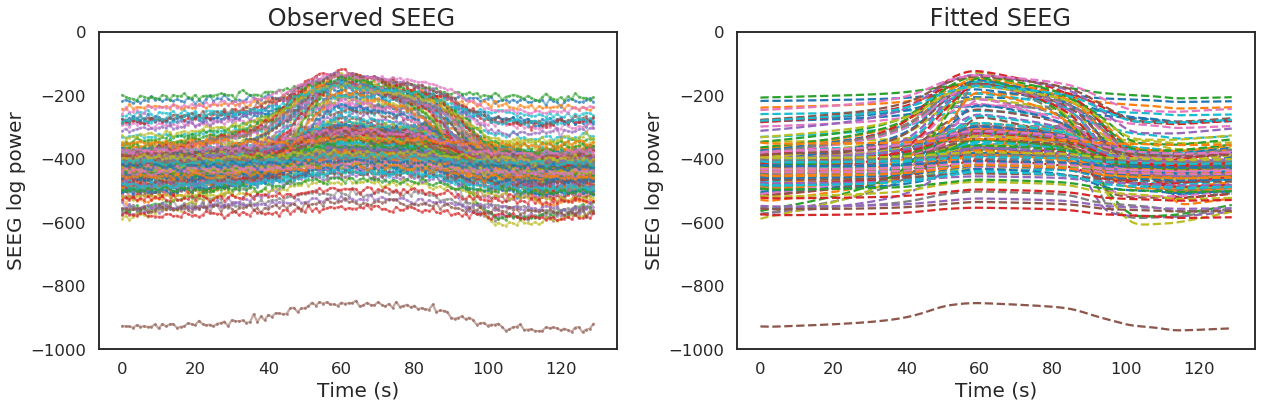

In [73]:
plt.figure(figsize=(18, 6)) 
subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep2_euler, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

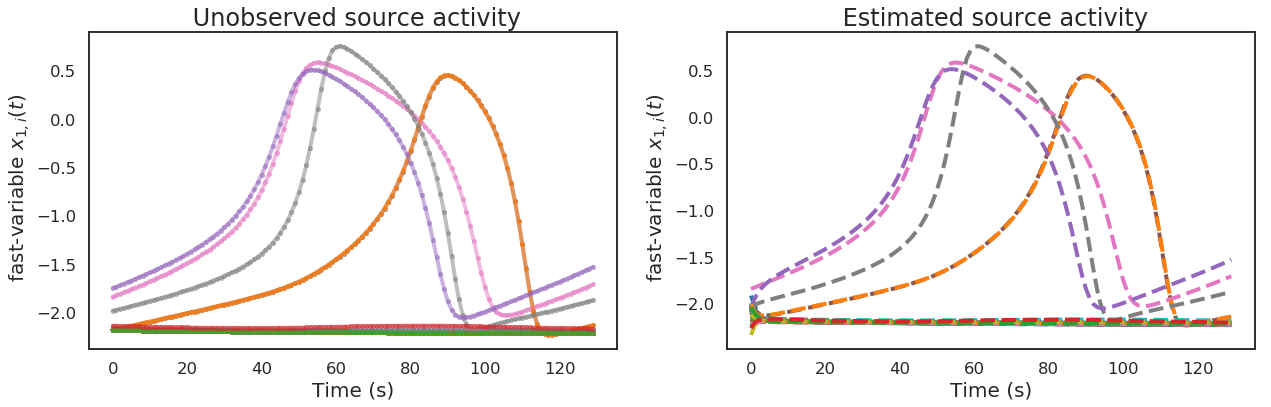

In [74]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep2_euler, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

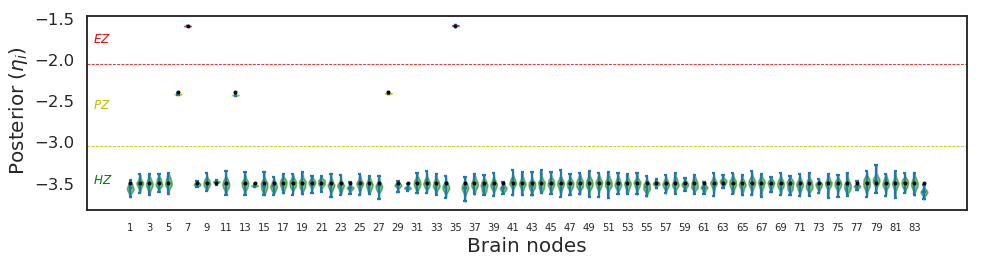

In [75]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep2_euler, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [76]:
np.mean(lp_bvep2_euler, axis=1)

array([-68745.444 , -68747.7005, -68745.6155, -68745.1805])

In [77]:
np.mean(stepsize_bvep2_euler, axis=1)

array([0.00474493, 0.00300232, 0.00405813, 0.00376017])

In [78]:
check_div(divergent_bvep2_euler.reshape(-1))

0.0

## 2.2) BVEP2 Heun integrator

In [79]:
solver=str('heun')

In [80]:
# %%bash

# alg=hmc
# solver=heun
# adap_delta=0.99
# max_depth=10
# num_iter=500
# warm_iter=2000

# model=BVEP_seeg_noncentered_reparam
# data_input=datainput_seeg_84nodes_patient1_heun.R
# data_output=data_output_${alg}_${model}_${solver}

# mkdir -p ${data_output}


# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
#         adapt \
#         delta=${adap_delta} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${max_depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_${solver}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_${solver}_$i.out &
# done
# #wait

In [81]:
fit_foldername="data_output_hmc_"+model+'_'+solver
fit_filename="output_hmc_"+model+'_'+solver

In [82]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_heun'

In [83]:
! ls $dir_data_output

output_hmc_BVEP2_seeg_noncentered_reparam_heun_1.csv
output_hmc_BVEP2_seeg_noncentered_reparam_heun_1.out
output_hmc_BVEP2_seeg_noncentered_reparam_heun_2.csv
output_hmc_BVEP2_seeg_noncentered_reparam_heun_2.out
output_hmc_BVEP2_seeg_noncentered_reparam_heun_3.csv
output_hmc_BVEP2_seeg_noncentered_reparam_heun_3.out
output_hmc_BVEP2_seeg_noncentered_reparam_heun_4.csv
output_hmc_BVEP2_seeg_noncentered_reparam_heun_4.out


In [84]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_heun/output_hmc_BVEP2_seeg_noncentered_reparam_heun_1.out <==
               27147.6 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_heun/output_hmc_BVEP2_seeg_noncentered_reparam_heun_2.out <==
               27504 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_heun/output_hmc_BVEP2_seeg_noncentered_reparam_heun_3.out <==
               28906.6 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_heun/output_hmc_BVEP2_seeg_noncentered_reparam_heun_4.out <==
               28175.3 seconds (Total)



## BVEP2 Heun all chains

In [85]:
nchains=4

In [86]:
run_time_bvep2_heun=np.zeros((nchains,1))
lp_bvep2_heun=np.zeros((nchains, nSample))
divergent_bvep2_heun=np.zeros((nchains, nSample))
stepsize_bvep2_heun=np.zeros((nchains, nSample))
Seeg_est_bvep2_heun=np.zeros((nchains, nSample, nt, ns))
x_est_bvep2_heun=np.zeros((nchains, nSample, nn, nt))
z_est_bvep2_heun=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep2_heun=np.zeros((nchains, nSample, nn))

In [87]:
for i in np.arange(0,nchains):
    
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

        with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
            lines = f.readlines()
            last_lines = lines[-7:]
            total_time_bvep2_heun=float(re.findall("\d+.\d+", last_lines[5])[0])
            print("convergence took: %s seconds " % total_time_bvep2_heun)
            
        run_time_bvep2_heun[i,0]=total_time_bvep2_heun
        
        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=int(num_samples),  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep2_heun[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep2_heun[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep2_heun[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep2_heun[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep2_heun[i,]=dict_samples['x'][-nSample:]
        z_est_bvep2_heun[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep2_heun[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP2_seeg_noncentered_reparam_heun_1.csv
convergence took: 27147.6 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_heun_2.csv
convergence took: 27504.0 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_heun_3.csv
convergence took: 28906.6 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_heun_4.csv
convergence took: 28175.3 seconds 


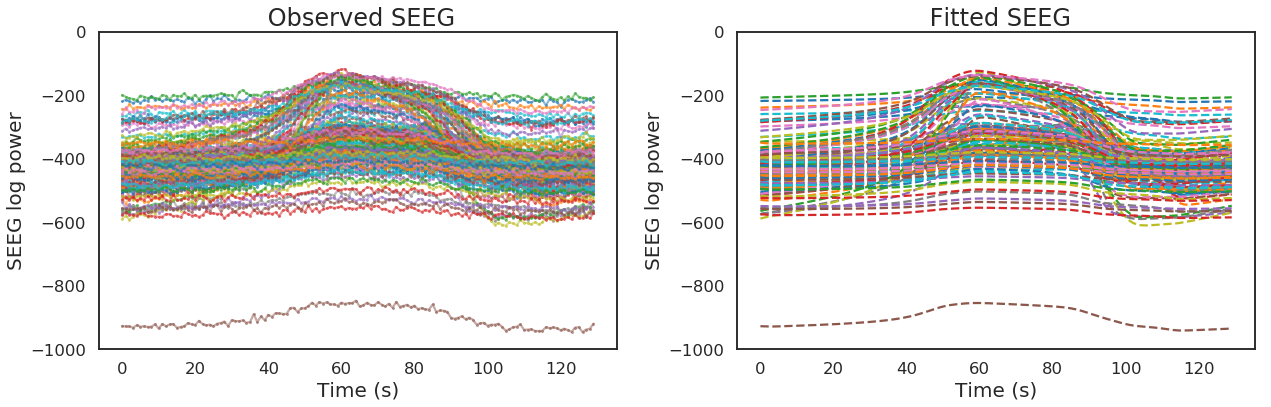

In [88]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep2_heun, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

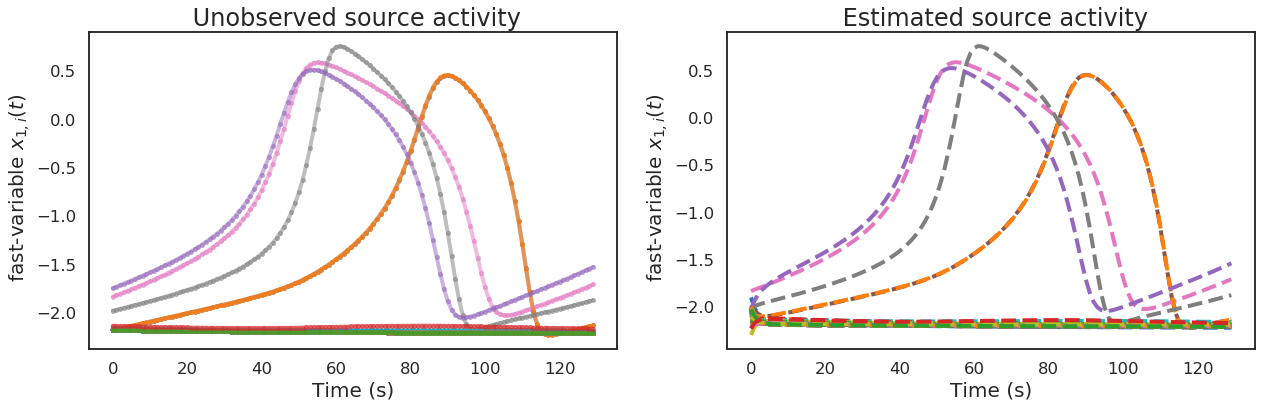

In [89]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep2_heun, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

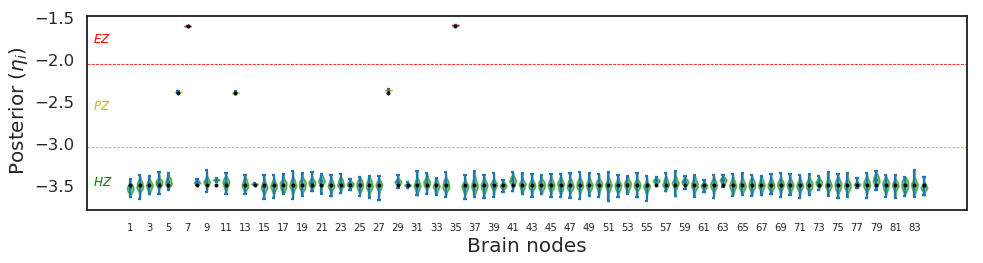

In [90]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep2_heun, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [91]:
np.mean(lp_bvep2_heun, axis=1)

array([-68923.1125, -68922.8175, -68923.202 , -68922.9145])

In [92]:
np.mean(stepsize_bvep2_heun, axis=1)

array([0.0040253 , 0.00567994, 0.0039644 , 0.00459472])

In [93]:
check_div(divergent_bvep2_heun.reshape(-1))

0.0

##  2.3) BVEP2 RK4 integrator

In [94]:
solver=str('rk4')

In [95]:
# %%bash

# alg=hmc
# solver=rk4
# adap_delta=0.99
# max_depth=10
# num_iter=500
# warm_iter=2000

# model=BVEP2_seeg_noncentered_reparam
# data_input=datainput_seeg_84nodes_patient1_rk4.R
# data_output=data_output_${alg}_${model}_${solver}

# mkdir -p ${data_output}


# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
#         adapt \
#         delta=${adap_delta} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${max_depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_${solver}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_${solver}_$i.out &
# done
# #wait

In [96]:
fit_foldername="data_output_hmc_"+model+'_'+solver
fit_filename="output_hmc_"+model+'_'+solver

In [97]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_rk4'

In [98]:
! ls $dir_data_output

output_hmc_BVEP2_seeg_noncentered_reparam_rk4_1.csv
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_1.out
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_2.csv
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_2.out
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_3.csv
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_3.out
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_4.csv
output_hmc_BVEP2_seeg_noncentered_reparam_rk4_4.out


In [99]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_rk4/output_hmc_BVEP2_seeg_noncentered_reparam_rk4_1.out <==
               220213 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_rk4/output_hmc_BVEP2_seeg_noncentered_reparam_rk4_2.out <==
               205751 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_rk4/output_hmc_BVEP2_seeg_noncentered_reparam_rk4_3.out <==
               216807 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP2_seeg_noncentered_reparam_rk4/output_hmc_BVEP2_seeg_noncentered_reparam_rk4_4.out <==
               232007 seconds (Total)



## BVEP2 RK4 all chains

In [100]:
nchains=4

In [101]:
run_time_bvep2_rk4=np.zeros((nchains,1))
lp_bvep2_rk4=np.zeros((nchains, nSample))
divergent_bvep2_rk4=np.zeros((nchains, nSample))
stepsize_bvep2_rk4=np.zeros((nchains, nSample))
Seeg_est_bvep2_rk4=np.zeros((nchains, nSample, nt, ns))
x_est_bvep2_rk4=np.zeros((nchains, nSample, nn, nt))
z_est_bvep2_rk4=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep2_rk4=np.zeros((nchains, nSample, nn))

In [102]:
for i in np.arange(0,nchains):
    
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

        with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
            lines = f.readlines()
            last_lines = lines[-7:]
            total_time_bvep2_rk4=float(re.findall("\d+.\d+", last_lines[5])[0])
            print("convergence took: %s seconds " % total_time_bvep2_rk4)
            
        run_time_bvep2_rk4[i,0]=total_time_bvep2_rk4
        
        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=int(num_samples),  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep2_rk4[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep2_rk4[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep2_rk4[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep2_rk4[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep2_rk4[i,]=dict_samples['x'][-nSample:]
        z_est_bvep2_rk4[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep2_rk4[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP2_seeg_noncentered_reparam_rk4_1.csv
convergence took: 220213.0 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_rk4_2.csv
convergence took: 205751.0 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_rk4_3.csv
convergence took: 216807.0 seconds 
reading ... output_hmc_BVEP2_seeg_noncentered_reparam_rk4_4.csv
convergence took: 232007.0 seconds 


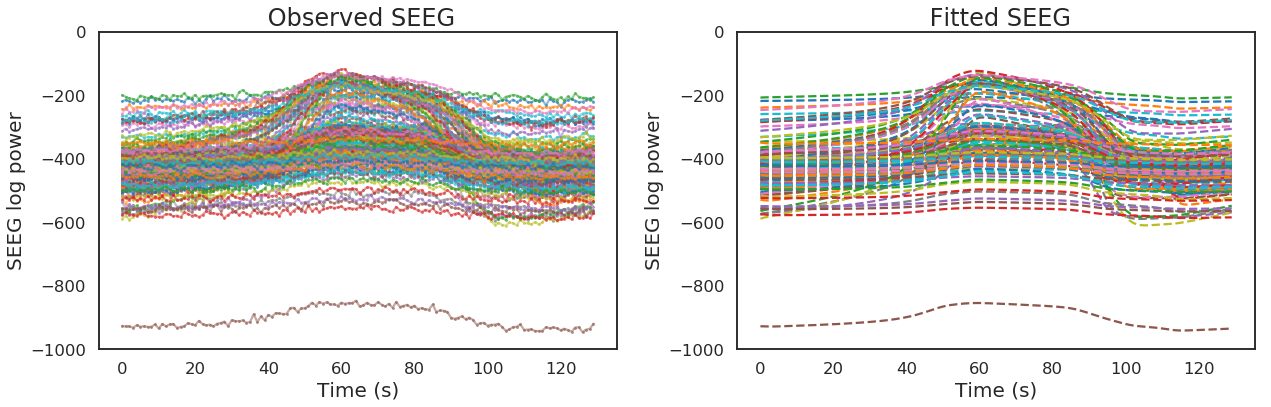

In [103]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep2_rk4, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

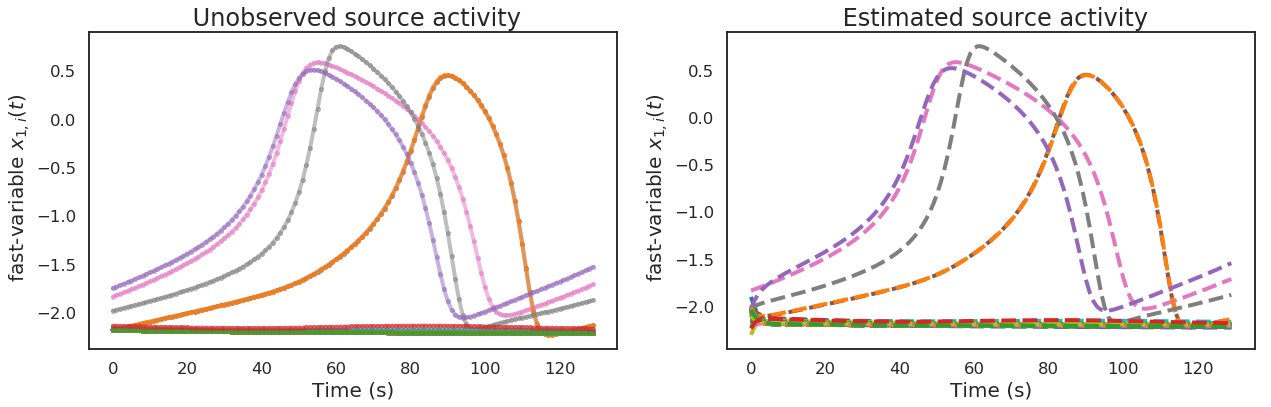

In [104]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep2_rk4, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

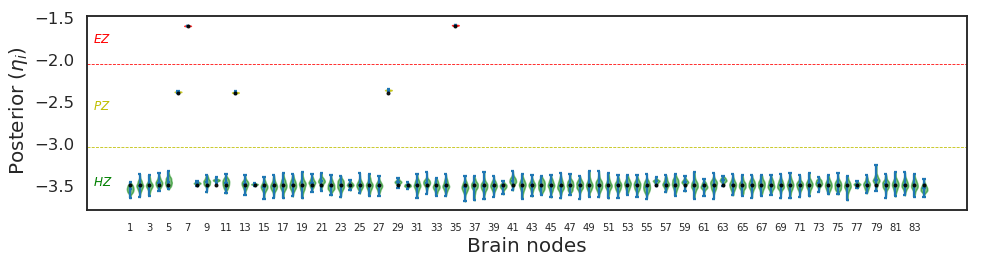

In [105]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep2_rk4, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [106]:
np.mean(lp_bvep2_rk4, axis=1)

array([-68902.296 , -68902.713 , -68901.166 , -68903.4825])

In [107]:
np.mean(stepsize_bvep2_rk4, axis=1)

array([0.00521023, 0.00339298, 0.0034612 , 0.00502513])

In [108]:
check_div(divergent_bvep2_rk4.reshape(-1))

0.0

## 3) Non-centerized form of parameterization,  sampling using eigen vectors of Gain Matrix, efficient coupling calculation through Structral Connectivity (SC) Matrix, and with Heun integrator in cpp

In [109]:
! cat BVEP3_seeg_noncentered_reparam.stan

functions {

  vector ode_rhs(real time, vector xz, matrix SC, real I1, real tau0, real K, vector eta) {
    int nn = rows(xz)/2;
    vector[nn] x = xz[1:nn];
    vector[nn] z = xz[nn+1:2*nn];
    vector[nn] gx = SC * x;
    vector[nn] dx = 1.0 - x.*x.*x - 2.0*x.*x - z + I1;
    vector[nn] dz = (1/tau0)*(4*(x - eta) - z - K*gx);
    return append_row(dx, dz);
  }
  
  vector ode_rhs_c(real time, vector xz, matrix SC, real I1, real tau0, real K, vector eta);

  vector ode_step(real time, real dt, vector xz, matrix SC, real I1, real tau0, real K, vector eta) {
    vector[rows(xz)] d1 = ode_rhs(time, xz, SC, I1, tau0, K, eta);
    vector[rows(xz)] d2 = ode_rhs(time+dt, xz+dt*d1, SC, I1, tau0, K, eta);
    return xz + dt / 2 * (d1 + d2);
  }

  vector ode_step_c(real time, real dt, vector xz, matrix SC, real I1, real tau0, real K, vector eta);

  matrix ode_sol_c(real dt, int nt, vector xz, matrix SC, real I1, real tau0, real K, vector eta);

  matrix ode_sol(real dt, int nt, vector xz, ma

In [110]:
model=str('BVEP3_seeg_noncentered_reparam')

In [111]:
solver=str('heuncpp')

In [112]:
PWD=cwd

In [113]:
#! STANCFLAGS='--allow-undefined' USER_HEADER=$$PWD/BVEP3inc.hpp make -C ~/cmdstan-2.28.2/ $$PWD/BVEP3_seeg_noncentered_reparam

In [114]:
# %%bash

# alg=hmc
# solver=heuncpp
# adap_delta=0.99
# max_depth=10
# num_iter=500
# warm_iter=2000

# model=BVEP3_seeg_noncentered_reparam
# data_input=datainput_seeg_84nodes_patient1_heun_cpp.R
# data_output=data_output_${alg}_${model}_${solver}

# mkdir -p ${data_output}


# for i in `seq 4`
# do
#     ./$model id=$i\
#         sample save_warmup=0 num_warmup=${warm_iter} num_samples=${num_iter} \
#         adapt \
#         delta=${adap_delta} \
#         algorithm=${alg} \
#         engine=nuts \
#         max_depth=${max_depth}  \
#         data file=data_input_files/${data_input}\
#         output file=${data_output}/output_${alg}_${model}_${solver}_$i.csv refresh=1 \
#         &> ${data_output}/output_${alg}_${model}_${solver}_$i.out &
# done
# #wait

In [115]:
fit_foldername="data_output_hmc_"+model+'_'+solver
fit_filename="output_hmc_"+model+'_'+solver

In [116]:
dir_data_output=cwd+"/"+fit_foldername
dir_data_output

'/data/BVEP_SEEG_benchmark/data_output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp'

In [117]:
! ls $dir_data_output

output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_1.csv
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_1.out
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_2.csv
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_2.out
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_3.csv
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_3.out
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_4.csv
output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_4.out


In [118]:
!tail -n2 $dir_data_output/*$model*out

==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp/output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_1.out <==
               18593.4 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp/output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_2.out <==
               19311.1 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp/output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_3.out <==
               19110.4 seconds (Total)


==> /data/BVEP_SEEG_benchmark/data_output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp/output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_4.out <==
               17562.7 seconds (Total)



## BVEP3 all chains

In [119]:
nchains=4

In [120]:
run_time_bvep3_heun=np.zeros((nchains,1))
lp_bvep3_heun=np.zeros((nchains, nSample))
divergent_bvep3_heun=np.zeros((nchains, nSample))
stepsize_bvep3_heun=np.zeros((nchains, nSample))
Seeg_est_bvep3_heun=np.zeros((nchains, nSample, nt, ns))
x_est_bvep3_heun=np.zeros((nchains, nSample, nn, nt))
z_est_bvep3_heun=np.zeros((nchains, nSample, nn, nt))
eta_est_bvep3_heun=np.zeros((nchains, nSample, nn))

In [121]:
for i in np.arange(0,nchains):
    
        fit_filename_csv= fit_filename +'_'+ str(i+1)+'.csv'
        fit_filename_out= fit_filename +'_'+ str(i+1)+'.out'

        print('reading ...', fit_filename_csv)

        num_samples, num_warmup, save_warmup,  adapt_delta, max_depth, total_time=hmc_config(dir_data_output+"/"+fit_filename_out)

        with open(dir_data_output+"/"+fit_filename_out, 'r') as f:
            lines = f.readlines()
            last_lines = lines[-7:]
            total_time_bvep3_heun=float(re.findall("\d+.\d+", last_lines[5])[0])
            print("convergence took: %s seconds " % total_time_bvep3_heun)
            
        run_time_bvep3_heun[i,0]=total_time_bvep3_heun
        
        dict_samples=read_samples(dir_data_output+"/"+str(fit_filename_csv), nwarmup=0, nsampling=int(num_samples),  variables_of_interest=['lp__', 'divergent__' , 'stepsize__', 'Seeg_qqc', 'x', 'z' , 'eta' ])
        lp_bvep3_heun[i,]=dict_samples['lp__'][-nSample:]
        divergent_bvep3_heun[i,]=dict_samples['divergent__'][-nSample:]
        stepsize_bvep3_heun[i,]=dict_samples['stepsize__'][-nSample:]
        Seeg_est_bvep3_heun[i,]=dict_samples['Seeg_qqc'][-nSample:]
        x_est_bvep3_heun[i,]=dict_samples['x'][-nSample:]
        z_est_bvep3_heun[i,]=dict_samples['z'][-nSample:]
        eta_est_bvep3_heun[i,]=dict_samples['eta'][-nSample:]

reading ... output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_1.csv
convergence took: 18593.4 seconds 
reading ... output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_2.csv
convergence took: 19311.1 seconds 
reading ... output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_3.csv
convergence took: 19110.4 seconds 
reading ... output_hmc_BVEP3_seeg_noncentered_reparam_heuncpp_4.csv
convergence took: 17562.7 seconds 


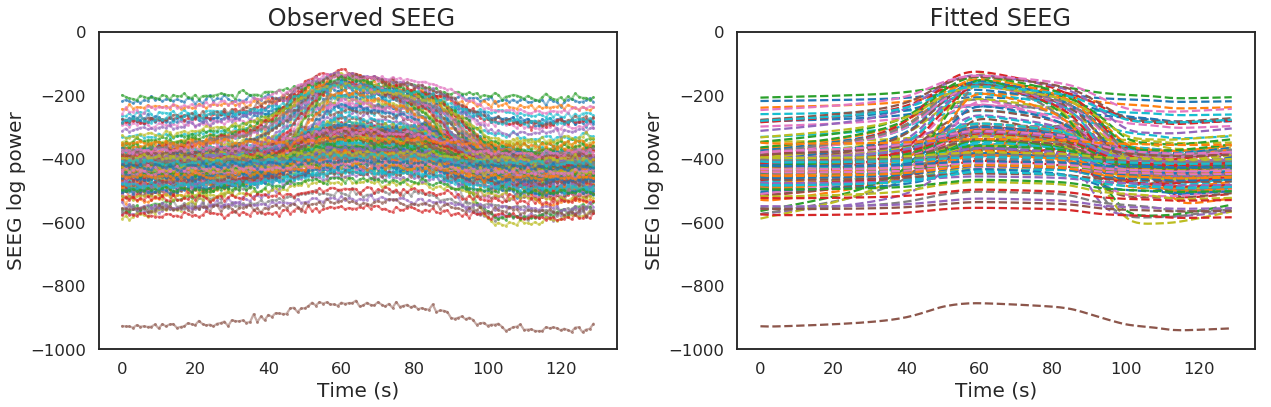

In [122]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, Seeg.T, alpha=0.5, marker= '.' , markersize=4)
plt.title(' Observed SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.subplot(122)
plt.plot(ts, np.mean(Seeg_est_bvep3_heun, axis=(0, 1)),  '--' , markersize=2)
plt.title(' Fitted SEEG', fontsize=24);  
plt.ylabel('SEEG log power', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.ylim((-1000,0))

plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSEEG"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

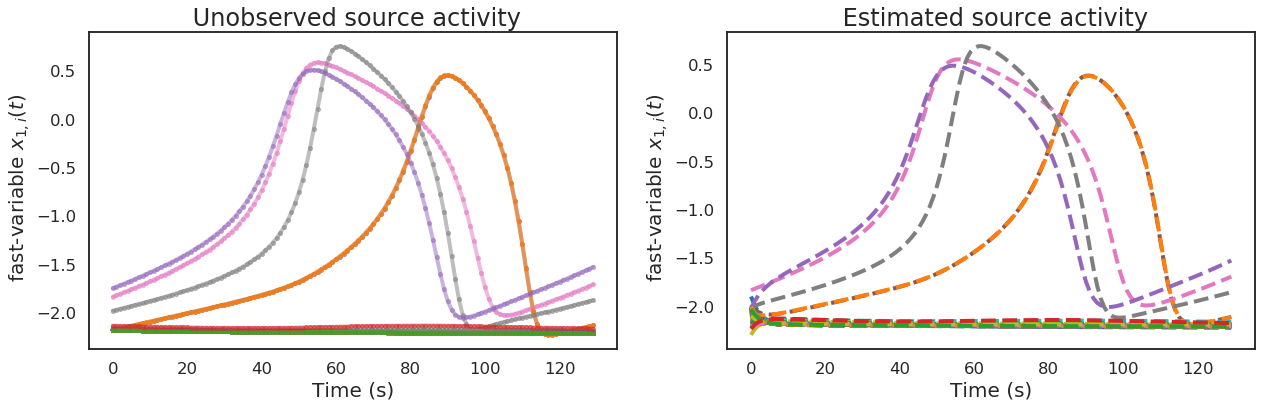

In [123]:
plt.figure(figsize=(18, 6)) 
plt.subplot(121)
plt.plot(ts, xs, alpha=0.5, marker= '.' , markersize=8, lw=4)
plt.title(' Unobserved source activity', fontsize=24);
plt.ylabel(' fast-variable ' + r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.subplot(122)
plt.plot(ts, np.mean(x_est_bvep3_heun, axis=(0, 1)).T,  '--' , markersize=8, lw=4)
plt.title(' Estimated source activity', fontsize=24);  
plt.ylabel(' fast-variable ' +r'$ x_{1,i}(t)$', fontsize=20);  
plt.xlabel('Time (s)', fontsize=20);
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"FittedSourceActivity"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

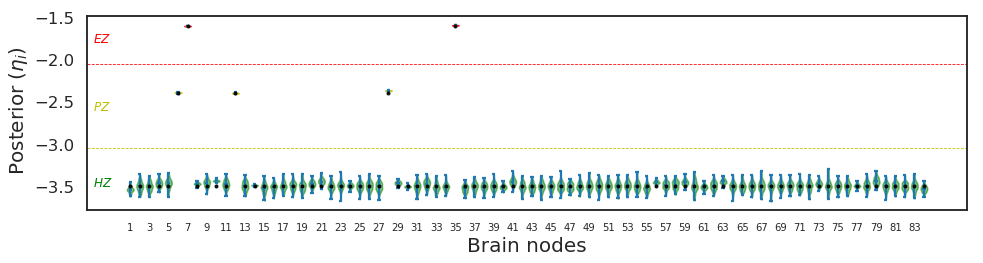

In [124]:
plt.figure(figsize=(14, 4)) 
plot_posterior(nodes, eta_c, delta_eta, eta_hz, eta_ez, eta_pz, np.asarray(Hz_indices), np.asarray(Ez_indices), np.asarray(Pz_indices), np.mean(eta_est_bvep3_heun, axis=0))
plt.xticks(np.arange(1,len(nodes)+2, step=2),np.arange(1, len(nodes)+1, step=2), fontsize=10, rotation=0)
plt.ylabel(' Posterior ' +r'${(\eta_i)}$', fontsize=20);  
plt.xlabel('Brain nodes', fontsize=20); 
plt.tight_layout()
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".png"), dpi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir)+'/figures',"PosteriorExcitability"+str(model)+"_allchains_"+".eps"), dpi=800)
plt.show()

In [125]:
np.mean(lp_bvep3_heun, axis=1)

array([-68925.065 , -68923.94  , -68924.681 , -68923.5445])

In [126]:
np.mean(stepsize_bvep3_heun, axis=1)

array([0.00480413, 0.00506879, 0.00536677, 0.00600867])

In [127]:
check_div(divergent_bvep3_heun.reshape(-1))

0.0

### Comparison of the algorithms

In [128]:
model_list = ['bvep1_euler', 'bvep2_euler', 'bvep2_heun', 'bvep2_rk4', 'bvep3_heun']

run_time_models_list = ["run_time_{:s}".format(i) for i in model_list]

lp_models_list = ["lp_{:s}".format(i) for i in model_list]

In [129]:
run_time_models=[np.mean(eval((run_time_models_list[i])), axis=1)  for i in range(len(model_list))]

In [130]:
np.mean(run_time_models, axis=1)

array([147265.   ,  16487.875,  27933.375, 218694.5  ,  18644.4  ])

In [131]:
lp_models=[np.mean(eval((lp_models_list[i])), axis=1)  for i in range(len(model_list))]

In [132]:
np.mean(lp_models, axis=1)

array([-68744.82375 , -68745.985125, -68923.011625, -68902.414375,
       -68924.307625])

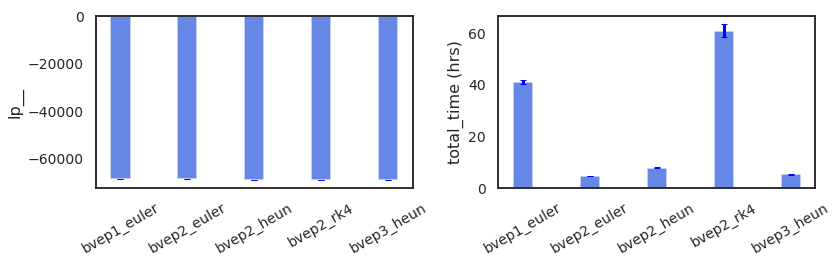

In [133]:
fig=figure(figsize=(12, 4))

error_kw= dict(ecolor='b', capsize=3, elinewidth=3)

ax1=subplot(121)

y=np.mean(lp_models, axis=1)
y_err=np.std(lp_models, axis=1)

plt.bar(range(len(y)), y, yerr=y_err, width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:5], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("lp__", fontsize=16)

ax2=subplot(122)

y=np.mean(run_time_models, axis=1)/3600
y_err=np.std(run_time_models, axis=1)/3600

plt.bar(range(len(y)), y, yerr=y_err, width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:5], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("total_time (hrs)", fontsize=16)

plt.tight_layout(w_pad=1)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark.eps"), doi=800)

plt.show()

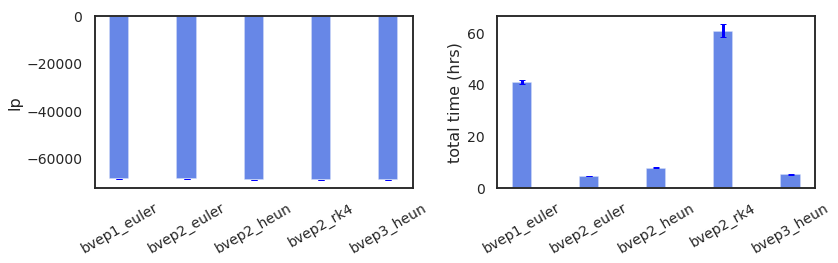

In [134]:
fig=figure(figsize=(12, 4))

error_kw= dict(ecolor='b', capsize=3, elinewidth=3)

ax1=subplot(121)

y=np.mean(lp_models, axis=1)
y_err=np.std(lp_models, axis=1)

plt.bar(range(len(y)), y, yerr=y_err, width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:5], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("lp", fontsize=16)

ax2=subplot(122)

y=np.mean(run_time_models, axis=1)/3600
y_err=np.std(run_time_models, axis=1)/3600

plt.bar(range(len(y)), y, yerr=y_err, width=0.3 ,color='royalblue', alpha=0.8, error_kw=error_kw)
plt.xticks(r_[:5], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("total time (hrs)", fontsize=16)

plt.tight_layout(w_pad=1)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark_barplot.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark_barplot.eps"), doi=800)

plt.show()

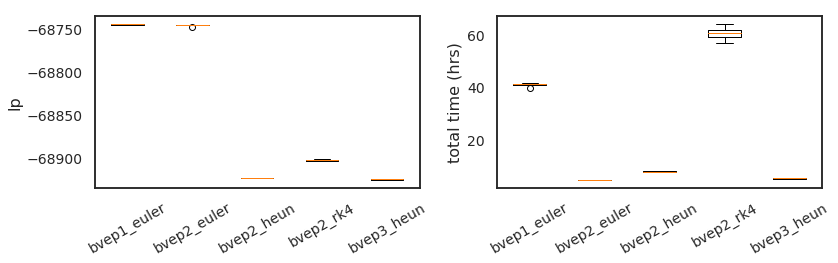

In [135]:
fig=figure(figsize=(12, 4))

error_kw= dict(ecolor='b', capsize=3, elinewidth=3)

ax1=subplot(121)

plt.boxplot(np.array(lp_models).T);

plt.xticks(r_[1:6], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("lp", fontsize=16)

ax2=subplot(122)

plt.boxplot(np.array(run_time_models).T/3600);

plt.xticks(r_[1:6], model_list, fontsize=14, rotation=30);
plt.yticks(fontsize=14);
#plt.xlabel("models", fontsize=16)
plt.ylabel("total time (hrs)", fontsize=16)

plt.tight_layout(w_pad=1)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark_boxplot.png"), doi=800)
plt.savefig(os.path.join(cwd+'/'+str(Res_dir),"bvep_benchmark_boxplot.eps"), doi=800)

plt.show()